In [1]:
%matplotlib inline


DQN PyTorch Implemetation
=====================================
**Author**: `Andres Quintela`

Based on the PyTorch DQN tutorial

Arcade Learning Environment on Acrobot

November 2018

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('Acrobot-v1').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Replay Memory
-------------

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    #saving a transition tuple
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
    #sample a random number according to batch size
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

Neural Network
-------------

In [4]:
class DQN(nn.Module):
    def __init__(self,input_size,action_size):
        super(DQN, self).__init__()
        
        self.hidden1 = nn.Linear(input_size,16)
        self.hidden2 = nn.Linear(16,16)
        #self.hidden3 = nn.Linear(16,16)
        self.output = nn.Linear(16,action_size)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        #x = F.relu(self.hidden3(x))
        return self.output(x.view(x.size(0), -1))
    

In [5]:
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.99
EPS_END = 0.05
EPS_DECAY = 1000
TARGET_UPDATE = 4
LEARNING_RATE=0.01


input_size=len(env.reset())
action_size=env.action_space.n



policy_net = DQN(input_size,action_size).to(device)
target_net = DQN(input_size,action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.SGD(policy_net.parameters(),lr=LEARNING_RATE)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(action_size)]], device=device, dtype=torch.long)

Training loop
--------------

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Main Loop
----------

In [7]:
num_episodes = 150
max_t=500  #maximum timesteps per episode

episode_reward=[0]*num_episodes
i_episode_reward=0


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state=env.reset()
    state=torch.tensor([state],dtype=torch.float,device=device)
    for t in count():
        
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        
        
        #give intermediate reward
        if (next_state[0]< 0):
            reward = torch.tensor([reward+1-next_state[0]], device=device)
        elif (next_state[0]>0):
            reward = torch.tensor([reward+(1-next_state[0])], device=device)
        else:
            reward = torch.tensor([reward], device=device)
        
        next_state=torch.tensor([next_state],dtype=torch.float,device=device)


        #accumulated reward for each episode
        i_episode_reward += reward.item()
        
        if done:
            next_state=None
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done or (t>max_t):
            #save episode reward
            episode_reward[i_episode]=i_episode_reward
            i_episode_reward=0
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

Complete


Text(0.5,1,'Acrobot')

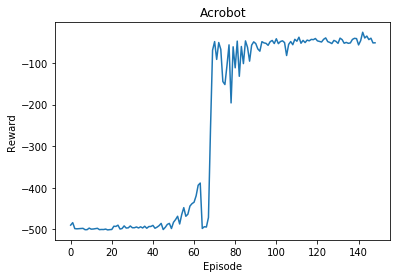

In [8]:
plt.plot(episode_reward[:i_episode])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Acrobot')